# Fiction Utterance Pairs: training a model with attention

## Import packages

In [0]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization, Embedding
# from tensorflow.keras.layers import CuDNNLSTM
# from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

## Initialize global variables

In [0]:
KERAS_DATASETS_DIR = '/content/gdrive/My Drive/tf2.0/'
U1_TRAINING_DATA_FILE = 'u1_train.npy'
U2_TRAINING_DATA_FILE = 'u2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'fiction_pairs_weights.h5'
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 50
DROPOUT = 0.2
BATCH_SIZE = 516

## Load the dataset, embedding matrix and word count

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os 
u1_data = np.load(os.path.join(KERAS_DATASETS_DIR, U1_TRAINING_DATA_FILE))
u2_data = np.load(os.path.join(KERAS_DATASETS_DIR, U2_TRAINING_DATA_FILE))
labels = np.load(os.path.join(KERAS_DATASETS_DIR, LABEL_TRAINING_DATA_FILE))
word_embedding_matrix = np.load(os.path.join(KERAS_DATASETS_DIR, WORD_EMBEDDING_MATRIX_FILE))
with open(os.path.join(KERAS_DATASETS_DIR, NB_WORDS_DATA_FILE), 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [0]:
# the below approach does not use 'split_tag' column in the csv file
X = np.stack((u1_data, u2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
U1_train = X_train[:,0]
U2_train = X_train[:,1]
U1_test = X_test[:,0]
U2_test = X_test[:,1]

## Define the model

In [6]:
utter1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
utter2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

u1 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(utter1)
u1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(u1)

u2 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(utter2)
u2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(u2)

attention = dot([u1,u2], [1,1])
attention = Flatten()(attention)
attention = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention)
attention = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention)

merged = add([u1,attention])
merged = Flatten()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(3, activation='softmax')(merged)

model = Model(inputs=[utter1,utter2], outputs=is_duplicate)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0502 09:19:22.014924 140342238386048 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa385cfdf60>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0502 09:19:22.023845 140342238386048 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa3852a8780>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0502 09:19:22.328431 140342238386048 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa3786fe128>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0502 09:19:22.331580 140342238386048 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa378520ef0>: Note that this layer is not optimized for performance. Please use tf.keras.laye

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      1256400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      1256400     input_2[0][0]                    
______________________________________________________________________________________________

## Train the model, checkpointing weights with best validation accuracy

In [8]:
print("Starting training at", datetime.datetime.now())
filepath = os.path.join(KERAS_DATASETS_DIR, "fiction_pair_epoch_{epoch:02d}.hdf5")
t0 = time.time()
callbacks = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,
                             mode='auto', period=1)]
history = model.fit([U1_train, U2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-05-02 09:19:23.099072
Train on 1044 samples, validate on 116 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.07738, saving model to /content/gdrive/My Drive/tf2.0/fiction_pair_epoch_01.hdf5
1044/1044 - 12s - loss: 1.6053 - accuracy: 0.3525 - val_loss: 1.0774 - val_accuracy: 0.5862
Epoch 2/50

Epoch 00002: val_loss improved from 1.07738 to 1.01207, saving model to /content/gdrive/My Drive/tf2.0/fiction_pair_epoch_02.hdf5
1044/1044 - 5s - loss: 1.3952 - accuracy: 0.3879 - val_loss: 1.0121 - val_accuracy: 0.7241
Epoch 3/50

Epoch 00003: val_loss improved from 1.01207 to 0.99559, saving model to /content/gdrive/My Drive/tf2.0/fiction_pair_epoch_03.hdf5
1044/1044 - 5s - loss: 1.3360 - accuracy: 0.3918 - val_loss: 0.9956 - val_accuracy: 0.7759
Epoch 4/50

Epoch 00004: val_loss improved from 0.99559 to 0.97723, saving model to /content/gdrive/My Drive/tf2.0/fiction_pair_epoch_04.hdf5
1044/1044 - 5s - loss: 1.3380 - accuracy: 0.3774 - val_loss: 0.9772

## Plot training and validation accuracy

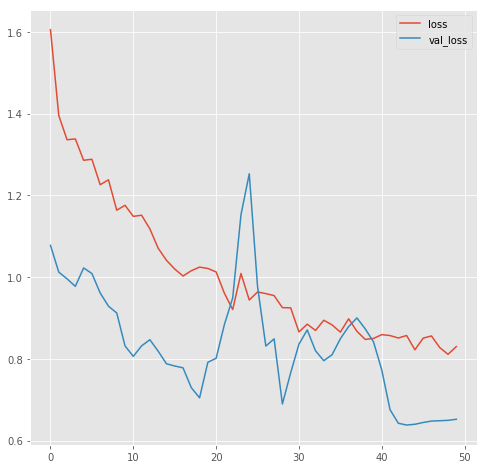

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend()
plt.show()

## Print best validation accuracy and epoch

In [10]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 50 = 0.8017


## Evaluate the model with best validation accuracy on the test partition

In [12]:
model.load_weights(os.path.join(KERAS_DATASETS_DIR, "fiction_pair_epoch_44.hdf5"))
loss, accuracy = model.evaluate([U1_test, U2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.7108, accuracy = 0.7442
